# **Convolutional Neural Network: Time Series Classification**
**Artificial  Neural  Networks  and  Deep  Learning  -  a.y.  2022/2023**

*     <u>Marco Bendinelli</u>
> M.Sc. Computer Science Engineering at Politecnico di Milano
>
> E-mail: marco.bendinelli@mail.polimi.it
>
> Student ID : 10673478
>
> Codalab Nickname: "MarcoBendinelli"
>
> Codalab Group: "Zero Neurons Networks"
*     <u>Pietro Andrea Cirino</u>
> M.Sc. Mathematical Engineering at Politecnico di Milano
>
> E-mail: pietroandrea.cirino@mail.polimi.it
>
> Student ID : 10628055
>
> Codalab Nickname: "PietroCirino"
>
> Codalab Group: "Zero Neurons Networks"
*     <u>Marco Cayuela</u>
> M.Sc. Mathematical Engineering at Politecnico di Milano
>
> E-mail: marco.cayuela@mail.polimi.it
>
> Student ID : 10859184
>
> Codalab Nickname: "MarcoCayou"
>
> Codalab Group: "Zero Neurons Networks"

## Environment settings

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/Homework 2/

### Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Random seed

In [ ]:
# Random seed for reproducibility
seed = 2710

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Preprocessing

In [ ]:
# Load the dataset
# !unzip training_dataset_homework2.zip
x = np.load('x_train.npy')
y = np.load('y_train.npy')

In [ ]:
# Split train - test
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=seed)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1943, 36, 6) (1943,)
(486, 36, 6) (486,)


In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y=y_train, num_classes=12)
y_val = tfk.utils.to_categorical(y=y_val, num_classes=12)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

### Metadata

In [ ]:
input_shape = x_train.shape[1:]
nb_classes = y_train.shape[-1]
batch_size = 512
epochs = 1500
learning_rate = 1e-3

## ReNet Model

### Build the model

In [ ]:
def residual_block(input, filters):

    x = tfkl.Conv1D(filters=filters, kernel_size=3, padding='same')(input)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv1D(filters=filters, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv1D(filters=filters, kernel_size=5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)

    res = tfkl.Conv1D(filters=filters, kernel_size=5, padding='same')(input)
    res = tfkl.BatchNormalization()(res)

    output = tfkl.add([x, res])
    output = tfkl.Activation('relu')(output)

    return output

In [ ]:
def build_model(input_shape, nb_classes):

    input = tfkl.Input(input_shape)

    x = residual_block(input, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = tfkl.GlobalAveragePooling1D()(x)
    output = tfkl.Dense(nb_classes, activation='softmax')(x)


    model = tfk.models.Model(inputs=input, outputs=output)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=tfk.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 64)       1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 36, 64)       0           ['batch_normalization[0][0]']

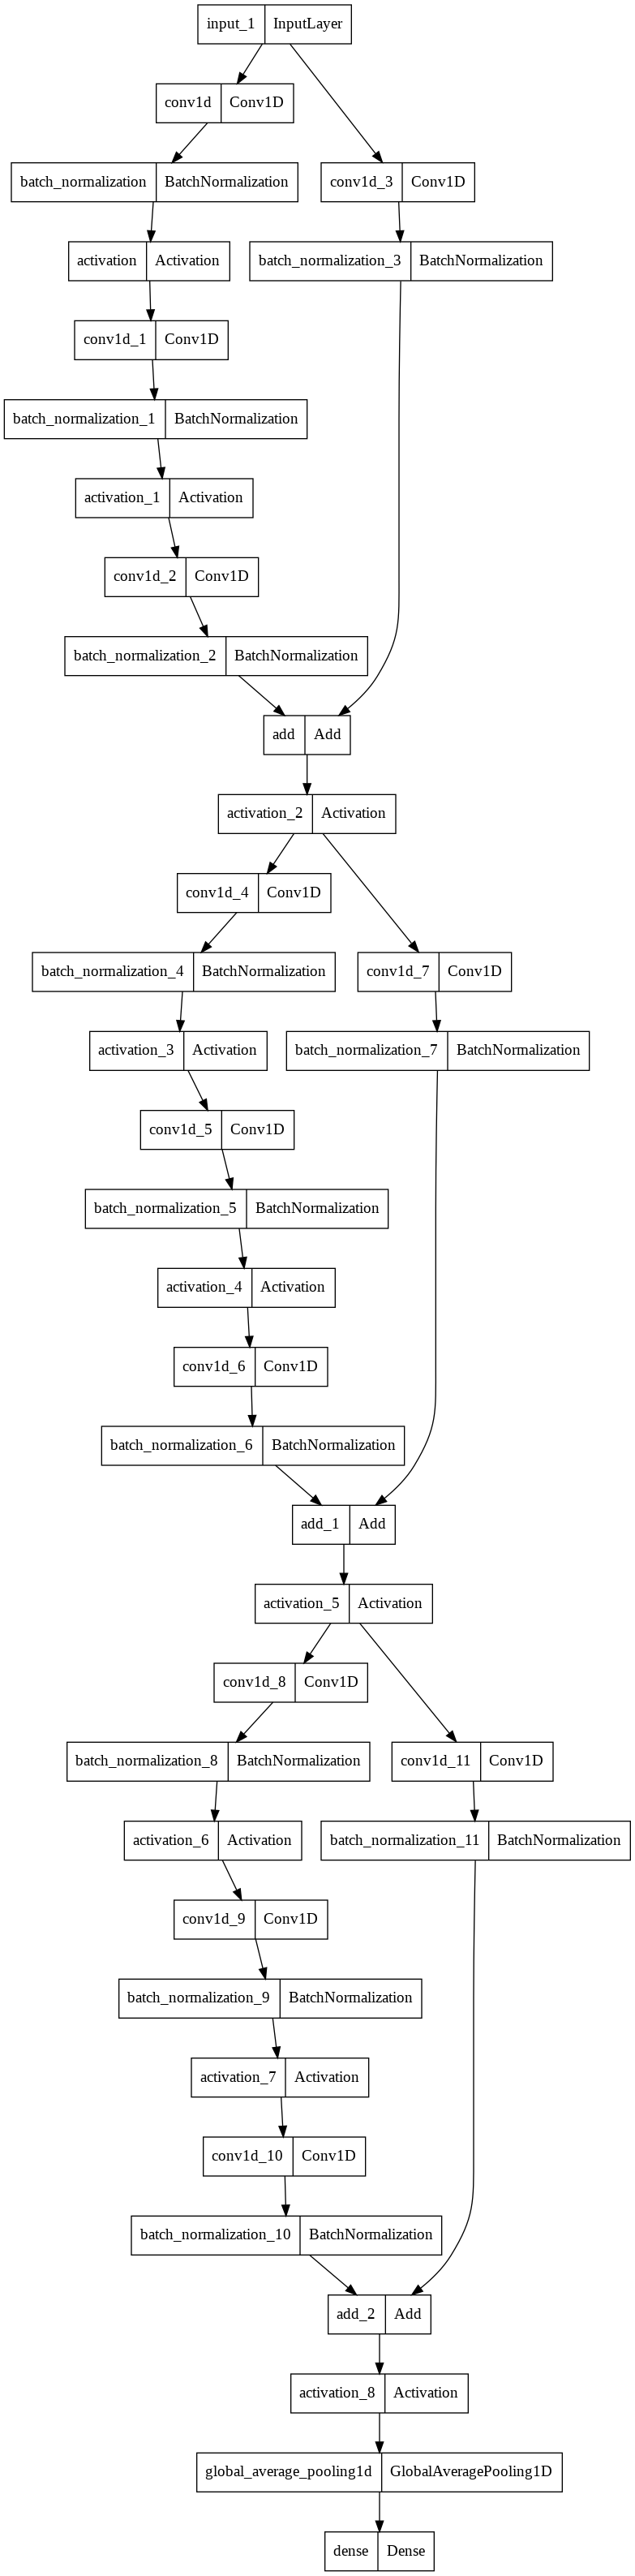

In [ ]:
model = build_model(input_shape, nb_classes)
model.summary()
tfk.utils.plot_model(model)

### Training and Validation

In [ ]:
# Train the model
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True),
                               tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=1e-5)]
                    ).history

Epoch 1/1500
4/4 [==============================] - 15s 879ms/step - loss: 2.4031 - accuracy: 0.2810 - val_loss: 3.0850 - val_accuracy: 0.0329 - lr: 0.0010
Epoch 2/1500
4/4 [==============================] - 0s 59ms/step - loss: 1.9884 - accuracy: 0.3778 - val_loss: 3.1710 - val_accuracy: 0.1029 - lr: 0.0010
Epoch 3/1500
4/4 [==============================] - 0s 61ms/step - loss: 1.7739 - accuracy: 0.4215 - val_loss: 2.8314 - val_accuracy: 0.1070 - lr: 0.0010
Epoch 4/1500
4/4 [==============================] - 0s 59ms/step - loss: 1.6059 - accuracy: 0.4668 - val_loss: 2.6660 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 5/1500
4/4 [==============================] - 0s 58ms/step - loss: 1.4756 - accuracy: 0.5111 - val_loss: 2.4150 - val_accuracy: 0.2016 - lr: 0.0010
Epoch 6/1500
4/4 [==============================] - 0s 58ms/step - loss: 1.3693 - accuracy: 0.5317 - val_loss: 2.3082 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 7/1500
4/4 [==============================] - 0s 58ms/step - loss: 1

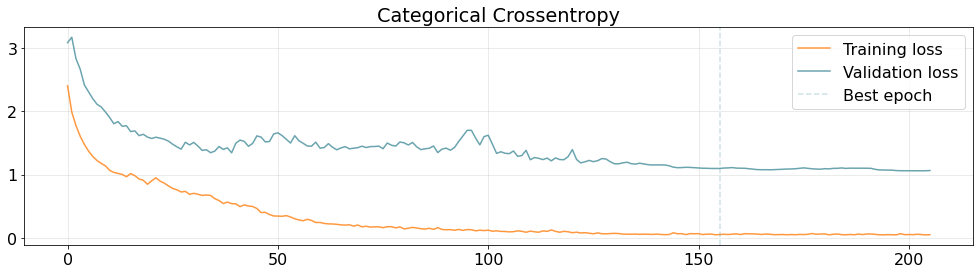

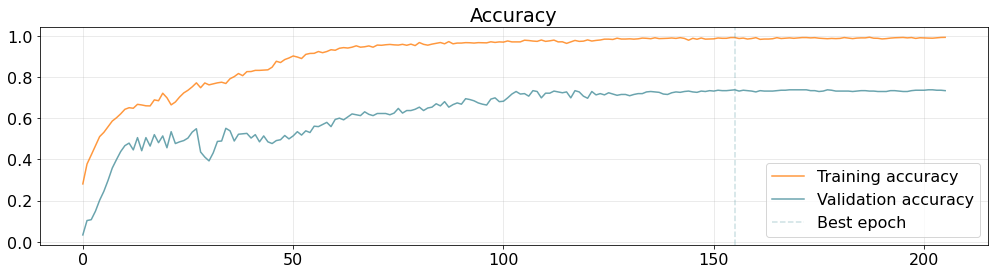

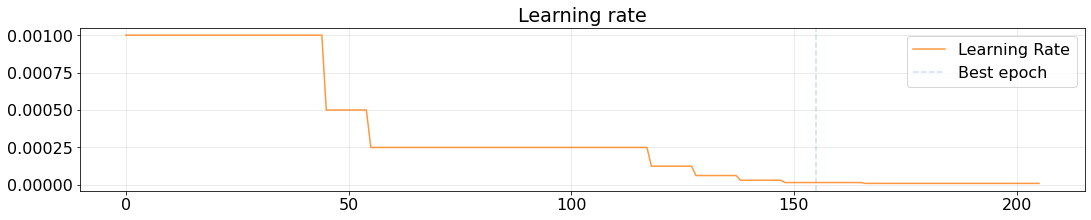

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Learning rate')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Save the model

In [ ]:
# model.save('ResNet model')